Using device: cuda
Epoch [0], train_loss: 2.1693, train_acc: 0.1897, test_loss: 2.0504, test_acc: 0.2259
Epoch [0]: New best accuracy: 22.59%
Epoch [1], train_loss: 1.9136, train_acc: 0.2866, test_loss: 1.7523, test_acc: 0.3499
Epoch [1]: New best accuracy: 34.99%
Epoch [2], train_loss: 1.7562, train_acc: 0.3496, test_loss: 1.5179, test_acc: 0.4383
Epoch [2]: New best accuracy: 43.83%
Epoch [3], train_loss: 1.6337, train_acc: 0.3990, test_loss: 1.4373, test_acc: 0.4722
Epoch [3]: New best accuracy: 47.22%
Epoch [4], train_loss: 1.5481, train_acc: 0.4313, test_loss: 1.2991, test_acc: 0.5316
Epoch [4]: New best accuracy: 53.16%
Epoch [5], train_loss: 1.4723, train_acc: 0.4644, test_loss: 1.2403, test_acc: 0.5559
Epoch [5]: New best accuracy: 55.59%
Epoch [6], train_loss: 1.4037, train_acc: 0.4895, test_loss: 1.1410, test_acc: 0.5898
Epoch [6]: New best accuracy: 58.98%
Epoch [7], train_loss: 1.3376, train_acc: 0.5156, test_loss: 1.0694, test_acc: 0.6111
Epoch [7]: New best accuracy: 61.1

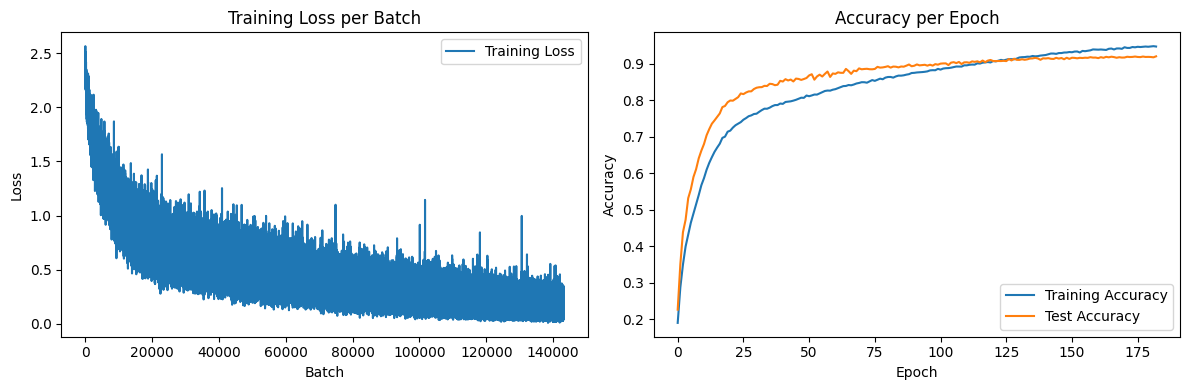

Final Test Accuracy with Best Model: 92.06%


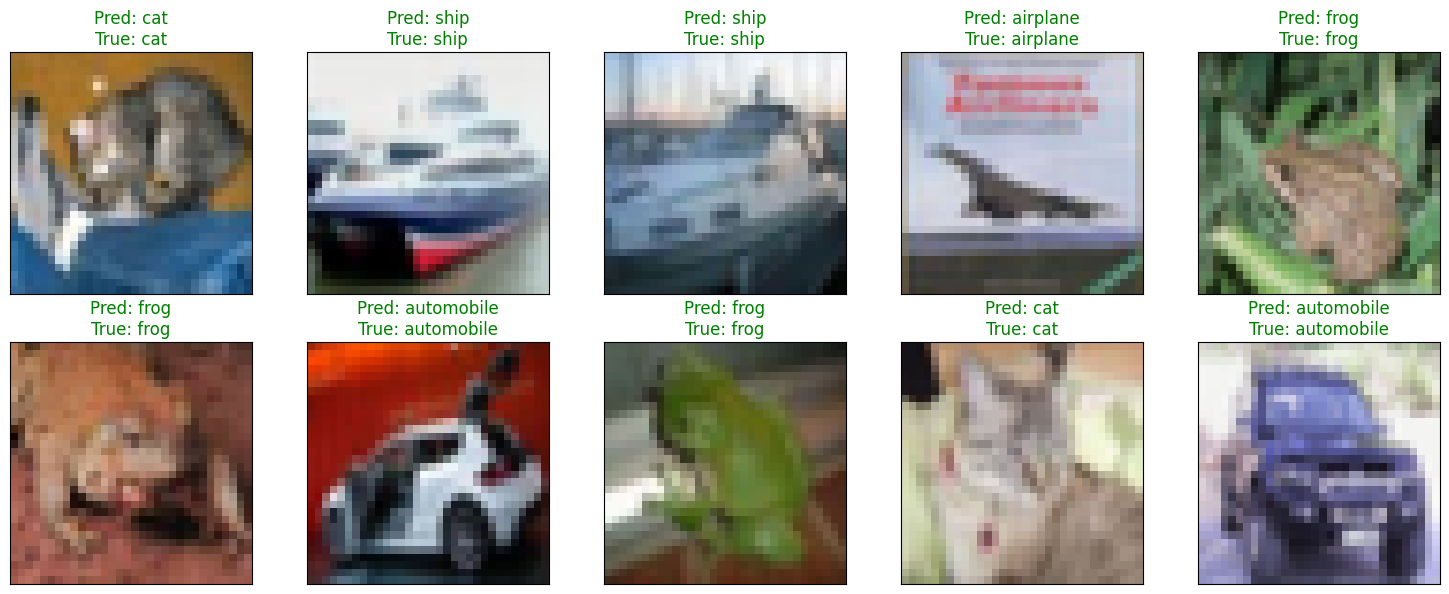

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Just normalization for testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Setup data loaders
torch.manual_seed(43)
batch_size = 64
num_workers = multiprocessing.cpu_count() - 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)
    def __len__(self):
        return len(self.dataloader)

train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'loss': loss, 'acc': acc}

    def test_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'test_loss': loss.detach(), 'test_acc': acc}

    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch, result['loss'], result['acc'], result['test_loss'], result['test_acc']))

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def evaluate(model, loader):
    model.eval()
    with torch.no_grad():
        outputs = [model.test_step(batch) for batch in loader]
    return model.test_epoch_end(outputs)

# Intermediate Block implementation as described in Section 2.1
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers=4, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.num_conv_layers = num_conv_layers
        self.conv_layers = nn.ModuleList()

        # Create L independent convolutional layers
        for i in range(num_conv_layers):
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True)
                )
            )

        # Fully connected layer to compute weights a
        self.fc = nn.Sequential(
            nn.Linear(in_channels, num_conv_layers),
            nn.Softmax(dim=1)  # Ensure weights sum to 1
        )

        # Mild improvement: residual connection if input/output channels match
        self.use_residual = (in_channels == out_channels)
        if not self.use_residual:
            self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = x

        # Compute average value of each channel (m vector)
        m = x.mean([2, 3])  # Global average pooling

        # Compute weights a using the fully connected layer
        a = self.fc(m)  # Shape: [batch_size, num_conv_layers]

        # Apply each convolutional layer to input x
        conv_outputs = [self.conv_layers[i](x) for i in range(self.num_conv_layers)]

        # Compute weighted sum x' = a₁C₁(x) + a₂C₂(x) + ... + aₗCₗ(x)
        x_prime = torch.zeros_like(conv_outputs[0])
        for i, conv_output in enumerate(conv_outputs):
            # Reshape a[:, i] to [batch_size, 1, 1, 1] for broadcasting
            weight = a[:, i].view(-1, 1, 1, 1)
            x_prime += weight * conv_output

        # Add residual connection if possible (mild improvement)
        if self.use_residual:
            x_prime = x_prime + identity
        elif hasattr(self, 'proj'):
            x_prime = x_prime + self.proj(identity)

        return x_prime

# Output Block implementation as described in Section 2.2
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super().__init__()

        # Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Linear(in_channels, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Compute average value of each channel (m vector)
        m = x.mean([2, 3])  # Global average pooling

        # Pass through fully connected layers to get output
        o = self.fc(m)

        return o

# Complete CIFAR10 model implementation with an extra intermediate block
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        # Define the intermediate blocks with increasing complexity
        self.block1 = IntermediateBlock(in_channels=3, out_channels=64, num_conv_layers=4)
        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2)
        )

        self.block2 = IntermediateBlock(in_channels=64, out_channels=128, num_conv_layers=4)
        self.trans2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2)
        )

        self.block3 = IntermediateBlock(in_channels=128, out_channels=256, num_conv_layers=4)
        self.trans3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        self.block4 = IntermediateBlock(in_channels=256, out_channels=512, num_conv_layers=4)
        self.trans4 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # Added extra intermediate block
        self.block5 = IntermediateBlock(in_channels=512, out_channels=512, num_conv_layers=4)
        self.trans5 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )

        # Output block for classification
        self.output_block = OutputBlock(in_channels=512, num_classes=10)

    def forward(self, x):
        # Pass through each intermediate block and transition layer
        x = self.block1(x)
        x = self.trans1(x)

        x = self.block2(x)
        x = self.trans2(x)

        x = self.block3(x)
        x = self.trans3(x)

        x = self.block4(x)
        x = self.trans4(x)

        # Pass through the extra intermediate block
        x = self.block5(x)
        x = self.trans5(x)

        # Pass through output block
        x = self.output_block(x)

        return x

# Function for computing accuracy (used by visualization code)
def compute_accuracy(model, data_loader):
    result = evaluate(model, data_loader)
    return result['test_acc'] * 100  # Convert to percentage

# Enhanced training function with learning rate scheduling, model saving, and early stopping
def fit(model, train_loader, test_loader, epochs=100, lr=0.001):
    history = []
    train_losses = []
    train_accs = []
    test_accs = []

    # AdamW optimizer with weight decay for regularization
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    # OneCycleLR scheduler for better convergence
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=epochs,
        steps_per_epoch=len(train_loader)
    )

    # Track best accuracy for model saving
    best_acc = 0

    for epoch in range(epochs):
        model.train()
        epoch_train_accs = []
        for batch in train_loader:
            optimizer.zero_grad()
            result = model.training_step(batch)
            loss = result['loss']
            acc = result['acc']
            train_losses.append(loss.item())
            epoch_train_accs.append(acc.item())
            loss.backward()
            optimizer.step()
            scheduler.step()

        train_acc = sum(epoch_train_accs) / len(epoch_train_accs)
        train_accs.append(train_acc)

        epoch_train_loss = sum(train_losses[-len(epoch_train_accs):]) / len(epoch_train_accs)

        result = evaluate(model, test_loader)

        result['loss'] = epoch_train_loss
        result['acc'] = train_acc

        model.epoch_end(epoch, result)
        test_accs.append(result['test_acc'])
        history.append(result)

        # Save the model if it has the best accuracy
        if result['test_acc'] > best_acc:
            best_acc = result['test_acc']
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Epoch [{epoch}]: New best accuracy: {best_acc*100:.2f}%")
        else:
            print(f"Epoch [{epoch}]: Current best accuracy: {best_acc*100:.2f}%")

        # Early stopping when accuracy reaches 92% or higher
        if result['test_acc'] * 100 >= 92.0:
            print(f"\n🎯 Target accuracy of 92% reached at epoch {epoch} with {result['test_acc']*100:.2f}%!")
            print("Stopping training early.")
            break

    # Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

    return history, train_losses, train_accs, test_accs

# Function to visualize predictions
def visualize_predictions(model, data_loader, num_images=10):
    model.eval()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck']

    # Get a batch of test images
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Plot images with predictions
    fig = plt.figure(figsize=(15, 6))
    for i in range(num_images):
        ax = fig.add_subplot(2, num_images//2, i+1, xticks=[], yticks=[])
        # Convert image from tensor to numpy
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        # Denormalize
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        title_color = 'green' if predicted[i] == labels[i] else 'red'
        ax.set_title(f'Pred: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}',
                     color=title_color)

    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Train the model
    model = CIFAR10Model().to(device)
    history, train_losses, train_accs, test_accs = fit(model, train_loader, test_loader, epochs=200, lr=0.001)

    # Load the best model and compute final test accuracy
    model.load_state_dict(torch.load('best_model.pth'))
    final_test_acc = compute_accuracy(model, test_loader)
    print(f"Final Test Accuracy with Best Model: {final_test_acc:.2f}%")

    # Visualize some predictions
    visualize_predictions(model, test_loader)